In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [4]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [5]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1.0,NaN,1,0,0,0,0.0,1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2.0,NaN,3,0,0,0,0.0,3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1.0,NaN,4,0,0,0,0.0,4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0.0,NaN,4,0,0,0,0.0,4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1.0,NaN,5,0,0,0,0.0,5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          632 non-null    object 
 1   Daily Confirmed                               631 non-null    float64
 2   False Positives Found                         523 non-null    float64
 3   Cumulative Confirmed                          632 non-null    int64  
 4   Daily Discharged                              632 non-null    int64  
 5   Passed but not due to COVID                   632 non-null    int64  
 6   Cumulative Discharged                         632 non-null    int64  
 7   Discharged to Isolation                       631 non-null    float64
 8   Still Hospitalised                            632 non-null    int64  
 9   Daily Deaths                                  631 non-null    flo

In [7]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [8]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [9]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [10]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [11]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [12]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [13]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               632 non-null    float64
 1   False Positives Found                         632 non-null    float64
 2   Cumulative Confirmed                          632 non-null    int64  
 3   Daily Discharged                              632 non-null    int64  
 4   Passed but not due to COVID                   632 non-null    int64  
 5   Cumulative Discharged                         632 non-null    int64  
 6   Discharged to Isolation                       632 non-null    float64
 7   Still Hospitalised                            632 non-null    int64  
 8   Daily Deaths                                  632 non-null    float64
 9   Cumulative Deaths                             632 non-null    int

<AxesSubplot:>

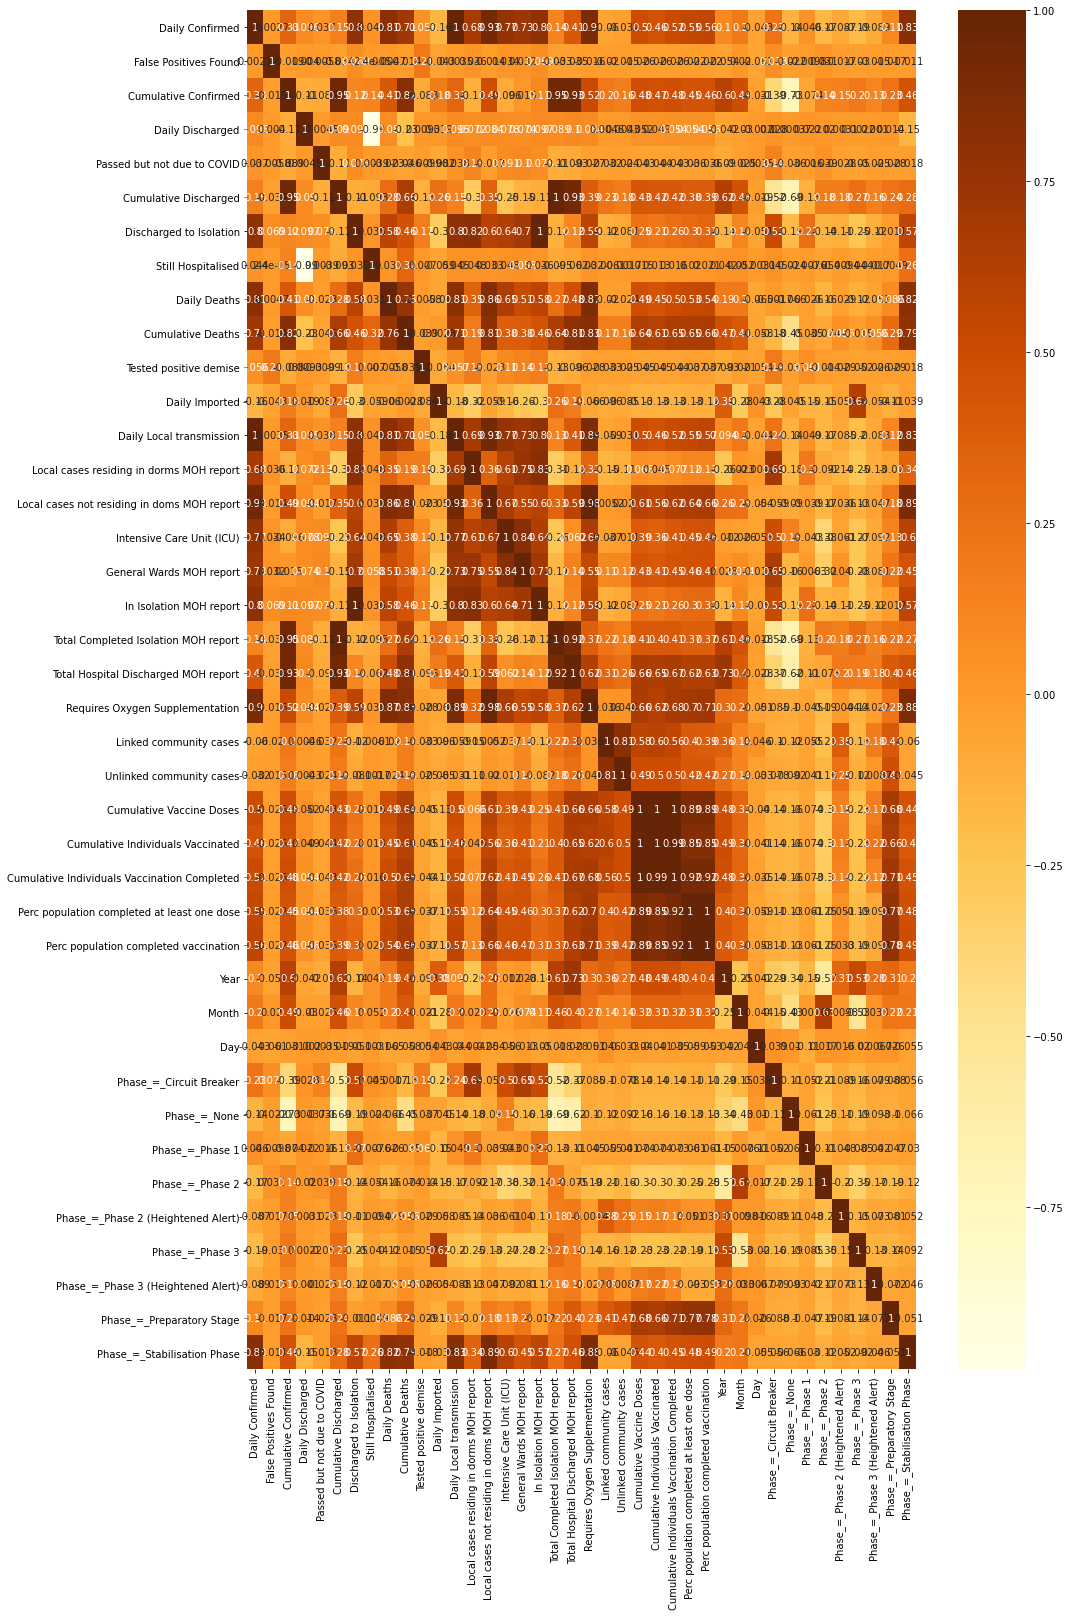

In [14]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [15]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Perc population completed vaccination"].sort_values(ascending=False)

Perc population completed vaccination           1.000000
Perc population completed at least one dose     0.998820
Cumulative Individuals Vaccination Completed    0.920745
Cumulative Vaccine Doses                        0.886851
Cumulative Individuals Vaccinated               0.848263
Phase_=_Preparatory Stage                       0.778992
Requires Oxygen Supplementation                 0.709834
Cumulative Deaths                               0.662742
Local cases not residing in doms MOH report     0.659988
Total Hospital Discharged MOH report            0.630979
Daily Local transmission                        0.565364
Daily Confirmed                                 0.564843
Daily Deaths                                    0.544323
Phase_=_Stabilisation Phase                     0.491757
General Wards MOH report                        0.466214
Intensive Care Unit (ICU)                       0.462689
Cumulative Confirmed                            0.455820
Unlinked community cases       

In [16]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [17]:
# pca.components_[0]

In [18]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [19]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Train Test Split & K Fold Cross Validation

In [20]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Perc population completed vaccination", axis=1)
y = sg_data_filtered["Perc population completed vaccination"]

In [21]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression

In [22]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [23]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for LR
MAE: 0.0020712860449542637
MSE: 1.1797473061317187e-05
RMSE: 0.003434744977624567
R-squared score for train: 0.9998644840832877
Adjusted R-squared score for train: 0.9998555565144502
R-squared score for test: 0.9998399548971229
Adjusted R-squared score for test: 0.9998294113852779


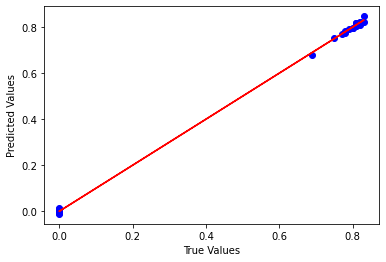

In [24]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

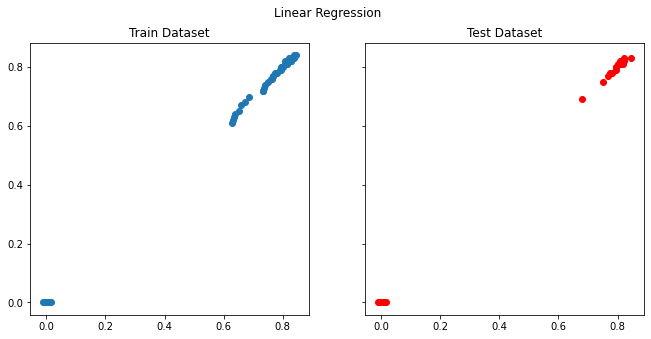

In [25]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [26]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
26,Perc population completed at least one dose,7.858330e-01
37,Phase_=_Preparatory Stage,2.403904e-02
36,Phase_=_Phase 3 (Heightened Alert),1.659243e-03
10,Tested positive demise,8.457093e-04
2,Cumulative Confirmed,5.769541e-04
1,False Positives Found,5.748542e-05
19,Total Hospital Discharged MOH report,3.645497e-05
21,Linked community cases,1.860554e-05
0,Daily Confirmed,1.495112e-05
11,Daily Imported,8.895977e-06


# Ridge Regression

In [27]:
# build lasso model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34012671851556386, tolerance: 0.002920718902953587
  model = cd_fast.enet_coordinate_descent(


In [28]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Lasso
MAE: 0.012028744724420346
MSE: 0.0018223483412172453
RMSE: 0.04268897212650177
R-squared score for train: 0.9763622112538388
Adjusted R-squared score for train: 0.974804992062791
R-squared score for test: 0.975277932296834
Adjusted R-squared score for test: 0.9736492825663889


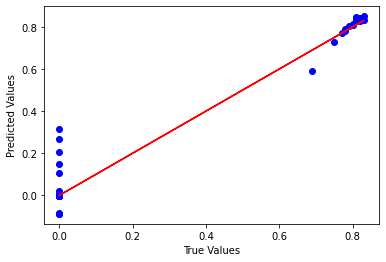

In [29]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

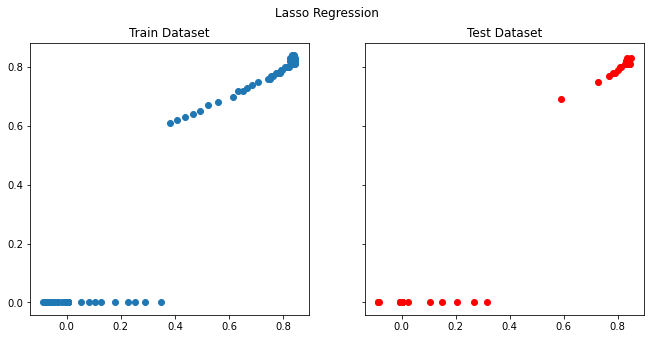

In [30]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [31]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
25,Cumulative Individuals Vaccination Completed,5.542235e-07
0,Daily Confirmed,-0.000000e+00
1,False Positives Found,-0.000000e+00
21,Linked community cases,-0.000000e+00
22,Unlinked community cases,-0.000000e+00
26,Perc population completed at least one dose,0.000000e+00
27,Year,0.000000e+00
28,Month,0.000000e+00
29,Day,-0.000000e+00
30,Phase_=_Circuit Breaker,0.000000e+00
